In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [10]:
# ------------------------------------------------------------
# (1) MODEL PARAMETERS
# ------------------------------------------------------------
def mc_binomial_asian(S0, K, r, sigma, T, N, Ns, u, m, d, pu, pd):
    
    dt = T / N
    np.random.seed(42)     # reproducible

    choices = [0, 1, 2]
    probs = [pd, 1-pd-pu, pu]

    X = np.random.choice(choices, size=(Ns, N), p=probs)   # (Ns × N) matrix    


    # ------------------------------------------------------------
    # (3) CONSTRUCT PRICE PATHS
    # ------------------------------------------------------------

    log_u = np.log(u)
    log_m = np.log(m)
    log_d = np.log(d)


    # Build log-steps according to X
    log_steps = (
        (X == 2) * log_u +
        (X == 1) * log_m +
        (X == 0) * log_d
    )

    # cumulative sum → log prices
    log_paths = np.cumsum(log_steps, axis=1)

    # full price paths (without S0 column)
    S_paths = S0 * np.exp(log_paths)          # shape (Ns, N)

    # optional: include S0 at t=0
    S_with_S0 = np.concatenate(
        [np.full((Ns, 1), S0), S_paths],
        axis=1
    )


    average_price = S_paths.mean(axis=1)
    payoff = np.maximum(average_price - K, 0)
    price = np.exp(-r*T) * payoff.mean()
    stderr = payoff.std(ddof=1) / np.sqrt(Ns)



    return price, stderr, S_with_S0




In [5]:
start = time.time()
price, stderr, S_paths = mc_binomial_asian(
    S0=100,
    K=100,
    r=0.05,
    sigma=0.2,
    T=1,
    N=15,
    Ns=10000,
    u=1.1,
    m=1.0,
    d=0.9,
    pu=0.2,
    pd=0.2)

end = time.time()
elapsed = end - start
print(f"Price: {price:.4f}, StdErr: {stderr:.4f}")
print(f"Elapsed time: {elapsed:.4f} seconds")

Price: 5.7151, StdErr: 0.0962
Elapsed time: 0.0734 seconds


In [ ]:
def smooth_outliers(arr, threshold):
    """
    Replace elements in arr that differ too much from neighbors.
    
    Parameters:
        arr (np.ndarray): 1D array of values.
        threshold (float): Maximum allowed difference between neighbors.
    
    Returns:
        np.ndarray: Smoothed array.
    """
    arr = arr.copy()  # Avoid modifying original
    n = len(arr)
    
    for i in range(1, n-1):
        prev_diff = abs(arr[i] - arr[i-1])
        next_diff = abs(arr[i] - arr[i+1])
        
        if prev_diff > threshold and next_diff > threshold:
            # Replace with average of neighbors
            arr[i] = (arr[i-1] + arr[i+1]) / 2
    
    return arr

# Example usage
arr = np.array([1, 1.1, 10, 1.3, 1.4])
smoothed = smooth_outliers(arr, threshold=2)
print(smoothed)

In [27]:
price_list = []
stderr_list = []
elapsed_list = []

for Ns in np.linspace(10000, 70000, 1000, dtype=int):
    start = time.time()
    price, stderr, S_paths = mc_binomial_asian(
        S0=100,
        K=100,
        r=0.05,
        sigma=0.2,
        T=1,
        N=17,
        Ns=Ns,
        u=1.1,
        m=1.0,
        d=0.9,
        pu=0.2,
        pd=0.2)
    end = time.time()
    elapsed = end - start

    price_list.append(price)
    stderr_list.append(stderr)
    elapsed_list.append(elapsed)

    print(f"Ns={Ns:>7}: Price: {price:.4f}, StdErr: {stderr:.4f}, Elapsed time: {elapsed:.4f} seconds")

Ns=  10000: Price: 5.9640, StdErr: 0.1012, Elapsed time: 0.0853 seconds
Ns=  10060: Price: 5.9600, StdErr: 0.1008, Elapsed time: 0.0298 seconds
Ns=  10120: Price: 5.9563, StdErr: 0.1005, Elapsed time: 0.0609 seconds
Ns=  10180: Price: 5.9576, StdErr: 0.1002, Elapsed time: 0.0272 seconds
Ns=  10240: Price: 5.9498, StdErr: 0.0998, Elapsed time: 0.0204 seconds
Ns=  10300: Price: 5.9472, StdErr: 0.0995, Elapsed time: 0.0217 seconds
Ns=  10360: Price: 5.9406, StdErr: 0.0992, Elapsed time: 0.0199 seconds
Ns=  10420: Price: 5.9299, StdErr: 0.0988, Elapsed time: 0.0188 seconds
Ns=  10480: Price: 5.9329, StdErr: 0.0986, Elapsed time: 0.0297 seconds
Ns=  10540: Price: 5.9540, StdErr: 0.0985, Elapsed time: 0.0214 seconds
Ns=  10600: Price: 5.9526, StdErr: 0.0981, Elapsed time: 0.0252 seconds
Ns=  10660: Price: 5.9654, StdErr: 0.0980, Elapsed time: 0.0275 seconds
Ns=  10720: Price: 5.9667, StdErr: 0.0978, Elapsed time: 0.0181 seconds
Ns=  10780: Price: 5.9776, StdErr: 0.0976, Elapsed time: 0.0131 

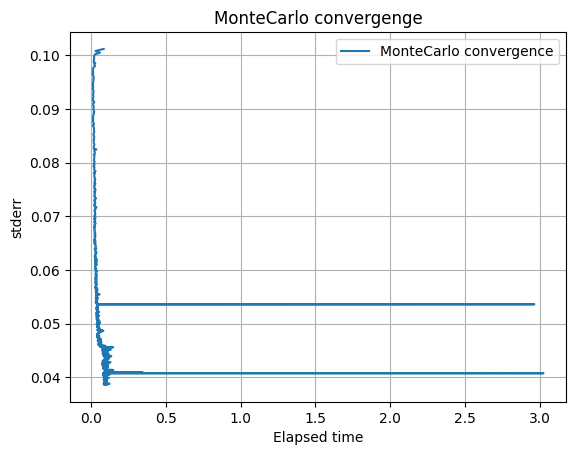

In [28]:
# Create the plot
plt.plot(elapsed_list, stderr_list, label='MonteCarlo convergence')
plt.xlabel('Elapsed time')
plt.ylabel('stderr')
plt.title('MonteCarlo convergenge')
plt.legend()
plt.grid(True)
plt.show()